# Тестовое задание Alfa

##### Содержание
<ol>
  <li>Задание 1 (SQL)
      <ol type="a">
          <li>SQL1</li>
          <li>SQL2</li>
          <li>SQL3</li>
      </ol></li>
  <li>Задание 2 (разметка и метрики)</li>
  <li>Задание 3 (когортный анализ)</li>
  <li>Задание 4 (портфолио)</li>
</ol>

## Задание 1 (SQL)
Приведите в качестве решения скриншот с результатом, скрипт (или ссылку на запрос
в среде, в которой решали задания, например http://sqlfiddle.com/), а также свои
комментарии относительно предложенного решения.
### SQL1
Отобрать клиентов по г. Москва с суммарными остатками по клиенту от 20 000 на последнюю дату. <br>
create table #Клиенты (client_id varchar(1), FIO varchar (255) , Region varchar(50), account_num int) <br>
insert into #Клиенты values  <br>
('A','Иванов','Москва',111), <br>
('A','Иванов','Москва',222), <br>
('B','Петров','Иваново',333), <br>
('C','Сидоров','Москва',444) <br><br>
   
create table #Cчета ([Date] date, Summa_USD money, Account_num int) <br>
insert into #Cчета values <br>
('2012-01-01',15000,111), <br>
('2012-02-01',10000,111), <br>
('2012-02-01',5000,222), <br>
('2012-03-01',30000,333), <br>
('2012-04-01',20000,444)<br>

### Решение
##### Fiddle
<p><img src="./imgs/screen_sql1.png" style="float:center;"></p>

##### Текстовый формат

In [ ]:
# Решение в текстовом формате
sql1 = '''
--Создание таблиц
create table clients (client_id varchar(1), FIO varchar (255) , Region varchar(50), account_num int);

insert into clients values
('A','Иванов','Москва',111),
('A','Иванов','Москва',222),
('B','Петров','Иваново',333),
('C','Сидоров','Москва',444);
   
create table acc_balance (date date, Summa_USD money, Account_num int);

insert into acc_balance values
('2012-01-01',15000,111),
('2012-02-01',10000,111),
('2012-02-01',5000,222),
('2012-03-01',30000,333),
('2012-04-01',20000,444);


--ЗАПРОС
with last_acc_balance as
	(
    --Последний баланс всех счетов клиентов из Москвы
    select distinct on (Account_num)
        c.client_id,
        c.FIO,

        ab.account_num,
        ab.summa_usd as balance_usd,
        ab.date as balance_change_date
    from acc_balance ab
    join clients c on ab.Account_num = c.account_num
    where c.Region = 'Москва'
    order by Account_num, date desc
    )
--Суммарный баланс клиентов г Москва с суммарным остатком по всем счетам более 20к$
select
	client_id,
    FIO,
    count(distinct account_num),
    sum(balance_usd)
from last_acc_balance
group by 1, 2
having sum(balance_usd)::numeric::float8 >= 20000;
'''

### SQL2
Таблица #oper хранит информацию о количестве произведенных операций на каждую календарную дату.  <br>
Вывести на каждую дату количества операций, совершенное с начала месяца по указанную дату включительно накопительным итогом. <br><br>
  
create table #oper (date date, cnt int) <br>
insert into #oper values <br>
('2019-06-02',     1985), <br>
('2019-06-03',     1577), <br>
('2019-06-04',     1597), <br>
('2019-06-05',     1468), <br>
('2019-07-06',     82), <br>
('2019-07-08',     1689), <br>
('2019-07-09',     1556), <br>
('2019-07-10',     1480), <br>
('2019-07-11',     1405), <br>
('2019-07-12',     1502) <br>
### Решение

##### Fiddle
<p><img src="./imgs/screen_sql2.png" style="float:center;"></p>

##### Текстовый формат

In [ ]:
# Решение в текстовом формате
sql2 = '''
--Создание таблиц
create table oper (date date, cnt int);

insert into oper values
('2019-06-02', 1985),
('2019-06-03', 1577),
('2019-06-04', 1597),
('2019-06-05', 1468),
('2019-07-06', 82),
('2019-07-08', 1689),
('2019-07-09', 1556),
('2019-07-10', 1480),
('2019-07-11', 1405),
('2019-07-12', 1502);


--ЗАПРОС
--Подневно кумулятивное в пределелах месяца количество операций
select
	date_trunc('month', o1.date) as month_,
    o1.date,
    sum(o2.cnt)
from oper o1
join oper o2 on o1.date >= o2.date
				and date_trunc('month', o1.date) = date_trunc('month', o2.date)
group by 1, 2
order by o1.date
'''

### SQL3
Даны месячные срезы сегментов клиентов, нужно получить по каждому клиенту периоды действия каждого сегмента. <br><br>
  
create table segment (date date, ClientID varchar(6),SegmentID int) <br>
insert into segment values  <br>
('2018-01-31' ,'A11111', 2), <br>
('2018-02-28' ,'A11111', 2), <br>
('2018-03-31' ,'A11111', 1), <br>
('2018-04-30' ,'A11111', 1), <br>
('2017-11-30' ,'B22222', 1), <br>
('2017-10-31' ,'B22222', 1), <br>
('2017-09-30' ,'B22222', 3), <br>
('2017-09-30' ,'C33333', 1), <br>
('2017-10-31' ,'C33333', 1) <br>

### Решение
Что значит строка ('2018-01-31' ,'A11111', 2)? Значит модель определения сегментов отработала в последний день месяца (31 января) и клиент (A11111) активен в сегменте (2) весь следующий месяц (февраль)? Буду считать, что так.<br>
              
В таблице нет кейсов, когда клиент попал в сегмент, пробыл в нём какое-то время, вывалился и спустя некоторые время опять попал в тот же сегмент. В реальной жизни такое есть, поэтому скрипт будет выглядеть сложнее, чем предполагается данными таблицы.<br>

##### Fiddle
<p><img src="./imgs/screen_sql3.png" style="float:center;"></p>

##### Текстовый формат

In [ ]:
# Решение в текстовом формате
sql3 = '''
--СОЗДАНИЕ ТАБЛИЦ
create table segment (date date, ClientID varchar(6),SegmentID int);

insert into segment values
('2018-03-31' ,'A11111', 1), 
('2018-04-30' ,'A11111', 1), 

('2017-09-30' ,'A11111', 2), --del
('2017-10-31' ,'A11111', 2), --del
('2017-11-30' ,'A11111', 2), --del

('2018-01-31' ,'A11111', 2), 
('2018-02-28' ,'A11111', 2), 
('2018-03-31' ,'A11111', 2),  --del

('2017-10-31' ,'B22222', 1), 
('2017-11-30' ,'B22222', 1), 

('2017-09-30' ,'B22222', 3), 

('2017-09-30' ,'C33333', 1), 
('2017-10-31' ,'C33333', 1);


--ЗАПРОС
with step1 as
    (
    --Находим месяц начала активности и месяц конца активности исходя из даты разметки
    select
        ClientID,
        SegmentID,
        date,
        date_trunc('month', date+1) as start_date,
        coalesce(lead(date_trunc('month', date+1)) over (partition by ClientID, SegmentID order by date), date_trunc('month', date+1)) as lead_date --следующий месяц активности
    from segment
    ),
    
    step2 as
    (
    --Разница между следующим месяцем разметки и текущим (запрос можно объединить с step3 - он чисто для понимания хода решения и красоты)
    select
        ClientID,
        SegmentID,
        date,
        start_date,
        lead_date,
        
        --Сколько месяцев между текущим месяцем активности в сегменте и следующим?
        (DATE_PART('year', lead_date) - DATE_PART('year', start_date)) * 12 + (DATE_PART('month', lead_date) - DATE_PART('month', start_date)) as diff
    from step1
    ), 
    
    step3 as
    (
    --Получем столбец для последующей группировки
    select
        ClientID,
        SegmentID,
        date,
        start_date,
        lead_date,
        diff,
      	
      	row_number() over(partition by ClientID, SegmentID order by date) as period_rn1,
      	row_number() over(partition by ClientID, SegmentID, diff order by date) as period_rn2,
      	
      	row_number() over(partition by ClientID, SegmentID order by date) - row_number() over(partition by ClientID, SegmentID, diff order by date) as grp
    from step2
    ),
    
    step4 as
    (
    --Обрабатываем крайние значения столбца группировки
    select
        ClientID,
        SegmentID,
        date,
        start_date,
        lead_date,
        diff,
        case
            when lead_date is not null then grp
            else coalesce(lag(grp) over(partition by ClientID, SegmentID order by date), grp)
        end as grp
    from step3
    ),
    
    step5 as
    (
    --Получаем группы периодов
    select
        ClientID,
        SegmentID,
        grp,
      	min(start_date)::varchar(10) || ' - ' || max(date_trunc('month', lead_date) + interval '1 month - 1 day')::varchar(10) as active_period
    from step4
    where (start_date = lead_date and diff <> 0)
      or (start_date <> lead_date)
    group by ClientID, SegmentID, grp
    )
--Вызываем таблицу
select
	ClientID,
   	SegmentID,
    active_period
from step5
order by ClientID, SegmentID, active_period
'''

## Задание 2 (разметка и метрики)
Партнерская витрина - это набор предложений партнеров банка, которые
предоставляют различного рода скидки нашим клиентам.<br><br>

<html>
 <head>
  <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
  <title></title>
  <style type="text/css">
   TABLE {
    width: 300px; /* Ширина таблицы */
    border-bottom: 2px solid maroon; /* Линия внизу таблицы */
    background: #fffacd; /* Цвет фона таблицы */
   }
   TH {
    background: maroon; /* Цвет фона заголовка */
    color: white; /* Цвет текста */
    text-align: left; /* Выравнивание по левому краю */
   }
   TD, TH {
    padding: 3px; /* Поля вокруг текста */
   }
  </style>
 </head> 
 <body> 
  <table cellspacing="0">
   <tr>
    <th>&nbsp;</th>
    <th><img src="./imgs/screen1.png" style="float:center;"></th>
    <th><img src="./imgs/screen2.png" style="float:center;"></th>
    <th><img src="./imgs/screen3.png" style="float:center;"></th>
   </tr>
  </table>
 </body>
</html><br>

На витрину можно перейти разными способами: через внешние и внутренние коммуникации (SMS, email, push, баннеры/уведомления внутри приложения).<br>
Партнеры могут предоставлять данные о совершенных нашими клиентами конверсиях (транзакциях).<br><br>

●	Какие наборы метрик для оценки эффективности партнерской витрины вы можете предложить?<br>
●	Опишите возможный набор систем и способы их интеграции, которые позволят осуществлять трекинг полного пути пользователя и его конверсионных действий.<br>
●	Какие сырые данные нужны и в каком виде для полноты картины?<br>
●	Какая разметка коммуникаций и действий пользователя вам понадобится для отслеживания всего пути клиента?

## Решение
Первое - а зачем нам предоставленные партнёрами данные о совершенных клиентами транзакциях, если у нас в распоряжении и так есть вообще все транзакции этих же клиентов в Альфе? Мы можем выбрать из них те, которые относятся к предложениям партнеров, сами.

И так, витрина существует, чтобы зарабатывать деньги. Это значит, что главная в ней метрика - это полученные нами деньги. Как банк получает деньги? Я думаю, что у каждой компании-партнера свой вид контракта с Альфа. Кто-то платит за новых для себя клиентов, кто-то платит только за первый заказ, кто-то за каждый. Назовём это "целевое событие". Сколько партнер платит за каждое целевое событие должно быть оговорено в контракте. Сколько раз это событие произойдет - зависит от Альфы.

Клиент совершивший целевое действие прошел через некоторую воронку с определенными этапами. Этапы могут быть разные - в зависимости от клиентского пути. Необходимо получить всё множество воронок со всевозможными в них этапами в контексте данной задачи.

В каждой воронке ключевая метрика - это **конверсия из первого этапа в последний**. Также исходя из воронки известно из каких конверсий состоит главная. По данным воронкам я и мониторил бы ситуацию (эффективность) витрины.

Насколько я знаю, сама система трекинга создаётся на этапе разработки приложения техническим специалистом. Он сам решает как она работает - отправляет события батчами или в конце часа, что прикреплять к событию - сессию, визит, utm/etm-метку, прошлое действие итд. Какие при этом трекать события известно - вешаем по 2 события на все интерактивные элементы - просмотр и клик, неинтерактивные одно - просмотр + логин, заход, разлогин и прочее. Не понимаю о каких системах идёт речь.

Какие сырые данные нужны - клики, просмотры и транзакции рассматриваемых клиентов.

Какая разметка коммуникаций и действий пользователя вам понадобится для отслеживания всего пути клиента? Такая же, какие способы коммуникаций и действий фактически существуют с клиентом в Альфе:)
Если это SMS, то каждая отправленная смс должна лежать где-то в отдельной табличке. Тоже самое с остальными каналами.
Если клиент может совершить какое-то действие, оно также должно быть залогировано.


P.s. Также, как и в прошлом вопросе - не понимаю причем здесь я, как аналитик:) Эти два вопроса ближе к BI и backend.

## Задание 3 (когортный анализ)
Приведите в качестве решения скриншот с результатом, а также свои комментарии относительно предложенного решения (с указанием среды, в которой решали задания). <br>
в приложенном файле хранятся данные об активности клиентов с сентября 2021 года по февраль 2022<br>
Необходимо на основе этих данных провести когортный анализ<br>
Данные: https://raw.githubusercontent.com/Propsih/test/main/data_test.csv<br>
Описание полей: <br>
CLIENT_ID - идентификатор клиента;<br> 
VALUE_DAY - отчетная дата; <br>
DIGITAL_30_CNT - кол-во входов в мобильное приложение за последние 30 дней на отчетную дату; <br>
TRAN_ACTIVE_30_CNT - кол-во транзакций в мобильном приложение за последние 30 дней на отчетную дату; <br>
OPER_ACTIVE_30_CNT - кол-во операций (транзакции+нефинансовые операции) в мобильном приложение за последние 30 дней на отчетную дату<br>

<ol>
<li>постройте визуальное представление удержания клиентов в статусе:</li>
<ul>
<li>активных клиентов банка (наличие строки для клиента на отчетную дату);</li>
<li>диджитал активных (активных в мобильном приложении: наличие хотя бы одного входа);</li>
<li>операционно активных;</li>
<li>транзакционно активных;</li>
    </ul>
</li>
<li>какие выводы можно сделать на основе этих данных?;</li>
<li>если построить проникновение транзакционно активных клиентов в когорты диджитал активных клиентов, то мы увидим, что существенная часть клиентов использует мобильное приложение, но не совершает транзакции (платежи и переводы) в нем. Какие гипотезы такого поведения можно предположить? Как их можно проверить ?;</li>
<li>как можно исправить эту ситуацию и увеличить проникновение транзакционно активных клиентов в диджитал активных?</li>
</ol>

## Решение

##### Откроем

In [2]:
import pandas as pd
import datetime as dt


data = "https://raw.githubusercontent.com/Propsih/test/main/data_test.csv"
data = pd.read_csv(data, delimiter=';')
data['VALUE_DAY'] = pd.to_datetime(data['VALUE_DAY'], format='%d.%m.%Y').dt.date
data

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT
0,3596869440,2021-09-30,18.0,8.0,9.0
1,181778433,2021-09-30,7.0,3.0,3.0
2,4271531990,2021-09-30,2.0,0.0,0.0
3,3949165697,2021-09-30,15.0,4.0,5.0
4,1926920317,2021-09-30,3.0,0.0,0.0
...,...,...,...,...,...
805816,4243322997,2022-02-28,2.0,0.0,0.0
805817,67461867,2022-02-28,3.0,0.0,0.0
805818,302417315,2022-02-28,NaN,NaN,NaN
805819,1780553365,2022-02-28,4.0,0.0,2.0


##### Количество клиентов

In [3]:
%%time
# 
df = data.copy(deep=True)

# активные клиенты
df_grp1 = df.groupby(by='VALUE_DAY', as_index=False)['CLIENT_ID'].nunique()
df_grp1['type'] = 'Активные'
df_grp1

# диджитал активные
cond = df['DIGITAL_30_CNT'] >= 1
df_grp2 = df.loc[cond].groupby(by='VALUE_DAY', as_index=False)['CLIENT_ID'].nunique()
df_grp2['type'] = 'Активные диджитал'
df_grp2

# операционно активные
cond = df['OPER_ACTIVE_30_CNT'] >= 1
df_grp3 = df.loc[cond].groupby(by='VALUE_DAY', as_index=False)['CLIENT_ID'].nunique()
df_grp3['type'] = 'Активные операционно'
df_grp3

# транзацкионно активные
cond = df['TRAN_ACTIVE_30_CNT'] >= 1
df_grp4 = df.loc[cond].groupby(by='VALUE_DAY', as_index=False)['CLIENT_ID'].nunique()
df_grp4['type'] = 'Активные транзацкионно'
df_grp4

# Активные как-то по другому
cond = (df['OPER_ACTIVE_30_CNT'].isna()) | (df['TRAN_ACTIVE_30_CNT'].isna()) | (df['TRAN_ACTIVE_30_CNT'].isna())
df_grp5 = df.loc[cond].groupby(by='VALUE_DAY', as_index=False)['CLIENT_ID'].nunique()
df_grp5['type'] = 'Активные по-другому'
df_grp5

# тотал
res = pd.concat([df_grp1, df_grp2, df_grp3, df_grp4, df_grp5], ignore_index=True)
res_pivot = pd.pivot_table(data=res, index='VALUE_DAY', columns='type', values='CLIENT_ID').reset_index().rename_axis(None, axis=1)
res_pivot

CPU times: user 386 ms, sys: 43.9 ms, total: 430 ms
Wall time: 429 ms


,VALUE_DAY,Активные,Активные диджитал,Активные операционно,Активные по-другому,Активные транзацкионно
0,2021-09-30,129232,112885,85414,15967,78372
1,2021-10-31,131637,114998,88108,16225,81411
2,2021-11-30,133009,116863,91616,15752,83634
3,2021-12-31,135957,119976,97769,15563,87133
4,2022-01-31,136770,120266,95748,16070,86557
5,2022-02-28,139214,123689,100289,15075,91642


<Axes: title={'center': 'Общее количество клиентов по типам'}, xlabel='VALUE_DAY', ylabel='CLIENT_ID'>

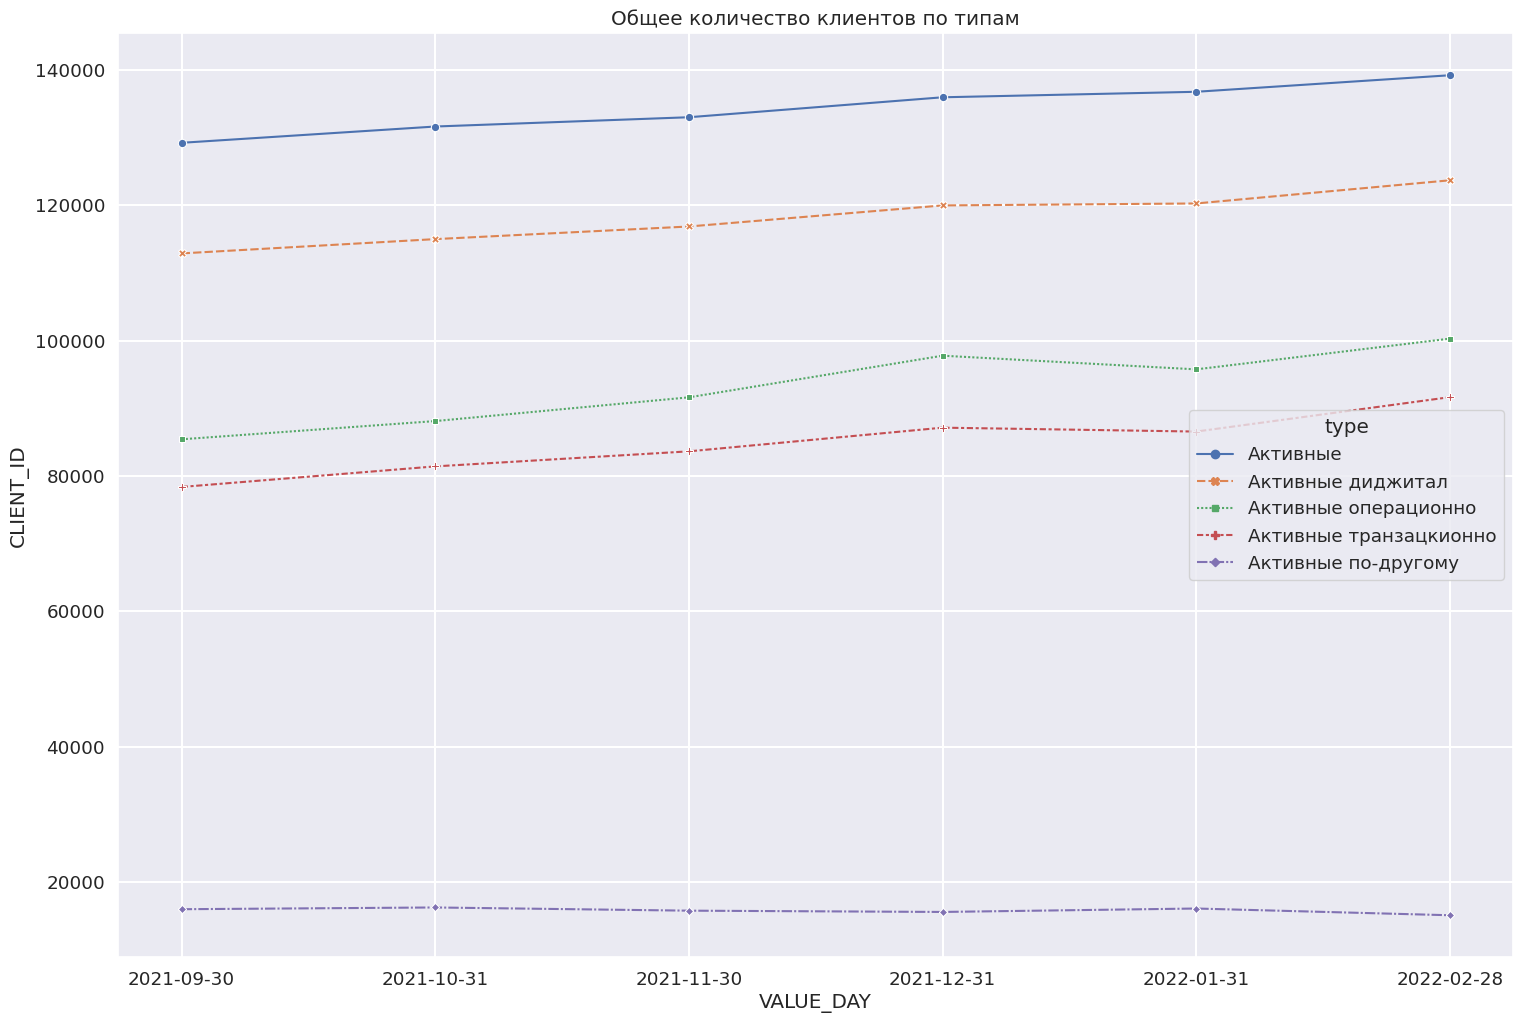

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
sns.set(font_scale=1.2)


a = res.copy(deep=True)
a['VALUE_DAY'] = a['VALUE_DAY'].astype('str')

plt.figure(figsize=(18, 12))
plt.title('Общее количество клиентов по типам')
plt.grid(color='white', linestyle='-', linewidth=1.5)
sns.lineplot(data=a, x='VALUE_DAY', y='CLIENT_ID', hue='type', markers=True, style="type", linewidth=1.5)

##### Retention tables  (п.1)
> <ol>
 <li>постройте визуальное представление удержания клиентов в статусе:</li>
 <ul>
 <li>активных клиентов банка (наличие строки для клиента на отчетную дату);</li>
 <li>диджитал активных (активных в мобильном приложении: наличие хотя бы одного входа);</li>
 <li>операционно активных;</li>
 <li>транзакционно активных;</li>
     </ul></ol>

Также добавим сюда тех клиентов, которые были активны как-то по-другому.

In [26]:
%%time
def diff_month(d1, d2):
    '''Функция возвращает разницу в месяцах между двумя датами'''
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def get_retention_table(df, cond, type_):
    '''
    Ф-ция формирует Retention table на основе одной и той же таблицы,
    но с разными условиями активности клиентов.
    '''
    if str(type(cond)) == "<class 'pandas.core.series.Series'>":
        df = df.loc[cond].reset_index(drop=True)
    
    # Первый месяц заказа клиента
    df['ClientFirstOrderMonth'] = df.groupby(by='CLIENT_ID', as_index=False)['VALUE_DAY'].transform('min')
    df

    # Номер месяца относительно первого заказа для клиента
    df['month_rn'] = df[['ClientFirstOrderMonth', 'VALUE_DAY']].apply(lambda x: diff_month(x[1], x[0]), axis=1)
    df

    # Получим группировку - кол-во клиентов в когортах
    df_grp1 = df.groupby(by=['ClientFirstOrderMonth', 'month_rn'], as_index=False)['CLIENT_ID'].nunique()
    df_grp1

    # Кол-во клиентов в нулевой когорте
    df_grp1_sub = df_grp1.loc[df_grp1['month_rn'] == 0].reset_index(drop=True).drop(columns=['month_rn']).rename(columns={'CLIENT_ID': 'cohort_base'})
    df_grp1 = df_grp1.merge(df_grp1_sub, how='left', on='ClientFirstOrderMonth')
    df_grp1

    # Retention
    df_grp1['Retention'] = (df_grp1['CLIENT_ID'] / df_grp1['cohort_base']).apply(lambda x: round(x, 2))
    df_grp1
    
    # type
    df_grp1['type'] = type_
    
    return df_grp1



# 
df = data.copy(deep=True)

# активные клиенты
cond = False
type_ = '0все активные клиенты'
df_retention1 = get_retention_table(df, cond, type_)

# диджитал активные
cond = df['DIGITAL_30_CNT'] >= 1
type_ = '1диджитал активные'
df_retention2 = get_retention_table(df, cond, type_)

# операционно активные
cond = df['OPER_ACTIVE_30_CNT'] >= 1
type_ = '2операционно активные'
df_retention3 = get_retention_table(df, cond, type_)

# транзацкионно активные
cond = df['TRAN_ACTIVE_30_CNT'] >= 1
type_ = '3транзацкионно активные'
df_retention4 = get_retention_table(df, cond, type_)

# Активные как-то по другому
cond = (df['OPER_ACTIVE_30_CNT'].isna()) | (df['TRAN_ACTIVE_30_CNT'].isna()) | (df['TRAN_ACTIVE_30_CNT'].isna())
type_ = '4Активные как-то по другому'
df_retention5 = get_retention_table(df, cond, type_)

# Общая таблица
total_table = pd.concat([df_retention1, df_retention2, df_retention3, df_retention4, df_retention5], ignore_index=True)
total_table

# Общий pivot
pivot_df = pd.pivot_table(total_table, index=['type', 'ClientFirstOrderMonth', 'cohort_base'], columns=['month_rn'], values=['Retention'])
pivot_df

CPU times: user 34.1 s, sys: 129 ms, total: 34.2 s
Wall time: 34.2 s


Retention         
month_rn                                                              0     1   
type                        ClientFirstOrderMonth cohort_base                   
0все активные клиенты       2021-09-30            129232            1.0  0.96  \
                            2021-10-31            7044              1.0  0.98   
                            2021-11-30            5841              1.0  0.98   
                            2021-12-31            6875              1.0  0.90   
                            2022-01-31            14770             1.0  0.97   
                            2022-02-28            5330              1.0   NaN   
1диджитал активные          2021-09-30            112885            1.0  0.94   
                            2021-10-31            9447              1.0  0.78   
                            2021-11-30            6759              1.0  0.80   
                            2021-12-31            7456              1.0  0.75   
                            2022-01-31            14166             1.0  0.92   
                            2022-02-28            5830              1.0   NaN   
2операционно активные       2021-09-30            85414             1.0  0.85   
                            2021-10-31            15811             1.0  0.63   
                            2021-11-30            10293             1.0  0.61   
                            2021-12-31            10341             1.0  0.51   
                            2022-01-31            14117             1.0  0.77   
                            2022-02-28            7132              1.0   NaN   
3транзацкионно активные     2021-09-30            78372             1.0  0.84   
                            2021-10-31            15679             1.0  0.62   
                            2021-11-30            9528              1.0  0.57   
                            2021-12-31            8735              1.0  0.51   
                            2022-01-31            13174             1.0  0.76   
                            2022-02-28            7128              1.0   NaN   
4Активные как-то по другому 2021-09-30            15967             1.0  0.65   
                            2021-10-31            5849              1.0  0.46   
                            2021-11-30            4832              1.0  0.45   
                            2021-12-31            4508              1.0  0.44   
                            2022-01-31            5153              1.0  0.47   
                            2022-02-28            3561              1.0   NaN   

                                                                            
month_rn                                                          2     3   
type                        ClientFirstOrderMonth cohort_base               
0все активные клиенты       2021-09-30            129232       0.93  0.90  \
                            2021-10-31            7044         0.98  0.72   
                            2021-11-30            5841         0.89  0.75   
                            2021-12-31            6875         0.90   NaN   
                            2022-01-31            14770         NaN   NaN   
                            2022-02-28            5330          NaN   NaN   
1диджитал активные          2021-09-30            112885       0.91  0.89   
                            2021-10-31            9447         0.74  0.61   
                            2021-11-30            6759         0.69  0.63   
                            2021-12-31            7456         0.72   NaN   
                            2022-01-31            14166         NaN   NaN   
                            2022-02-28            5830          NaN   NaN   
2операционно активные       2021-09-30            85414        0.84  0.83   
                            2021-10-31            15811        0.63  0.53   
                            2021-11-30            10293        0.51  0.51   
  

<Axes: title={'center': 'Retention Rate from zero to (0-5) next monthes'}, xlabel='None-month_rn', ylabel='type-ClientFirstOrderMonth-cohort_base'>

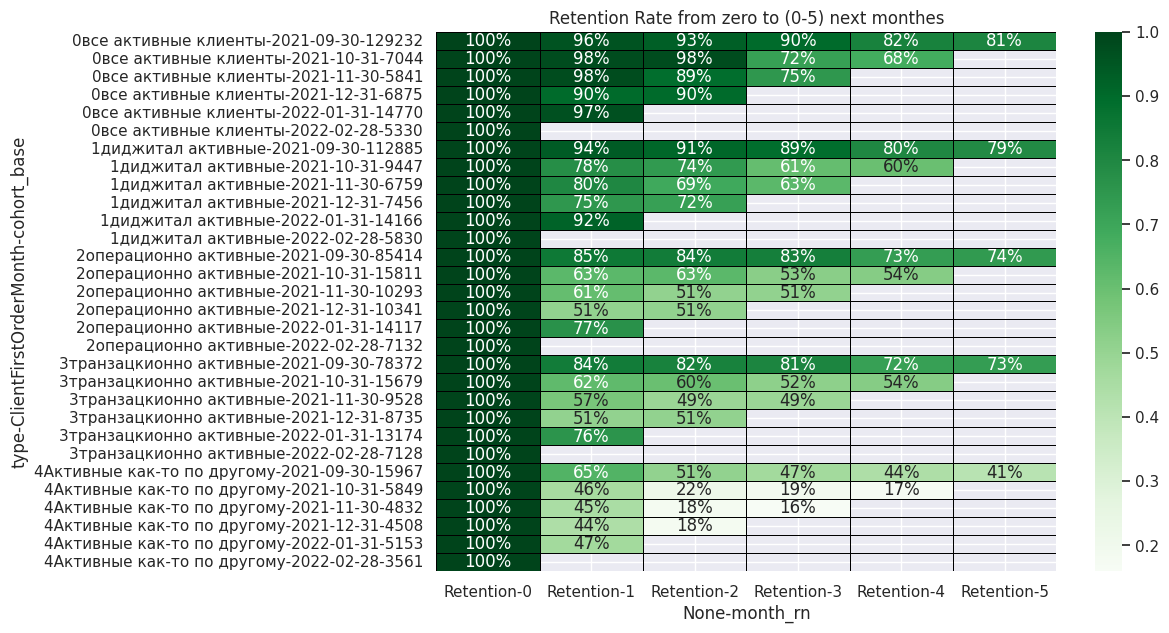

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)


# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(10, 7))
plt.title('Retention Rate from zero to (0-5) next monthes')
sns.heatmap(pivot_df, annot=True, 
            fmt='.0%', linewidths=.5, linecolor='black', cmap="Greens")

##### Выводы на основе данных  (п.2)
`Про Количество клиентов:`<br>
Количество активных клиентов планомерно растёт месяц к месяцу в основном за счёт роста диджитал-активных клиентов.<br>

При анализе транзакционно и операционно активных клиентов можно заметить, что их количество также растёт, но количество операционно активных приближаясь к Новому году растёт сильнее не смотря на более высокую базу. После локального пика в Янвраре следует падение - эффект похмелья, которое сильнее выражается также у операционно активных.<br>

`Про Retention:`<br>
Диджитал клиенты самые возвращающиеся клиенты из всех остальных типов. Второе место - операционно активные, третье - транзакционно. На тепловой карте можно заметить просадки в возращаемости в конкретные месяца, а именно в Январь среди клиентов с определённым типом активности. Вполне допустимо, что это просто сезонный тренд.<br>

Также есть такие клиенты среди общего числа активных, которые не были активны ни по одному из других типов - остальные (4й тип). Не знаю как еще можно быть активным, тем не менее видно, что у когорты Ноября21 наблюдается очень плавное снижение при том, что это самая большая по численности когорта. У клиентов следующих когорт (ноябрь-февраль) наблюдается резкое падение в два раза на 1й и на 2й месяц подряд. То есть, большинство этих клиентов - залётные (грубо говоря). Какая мотивация у них была и что они делали? Догадок не имею, но если нужно будет подумать, то готов:)<br>

##### Часть клиентов не совершает транзакции (п.3)
> если построить проникновение транзакционно активных клиентов в когорты диджитал активных клиентов, то мы увидим, что существенная часть клиентов использует мобильное приложение, но не совершает транзакции (платежи и переводы) в нем. Какие гипотезы такого поведения можно предположить? Как их можно проверить ?;

В приложении Альфы очень много других типов действий помимо платежей и переводов, которые может совершить клиент. Просто так зайти в приложение посмотреть баланс, изменить настройки, посмотреть рекламные или любые другие уведомления, открыть продукт и прочее прочее. Разумеется, оставшиеся клиенты заняты как раз всеми этими делами. Но это скорее не гипотеза, а факт.<br>

Конечно, мы можем разложить этот факт на составляющие. Мы можем сгруппировать событийную таблицу по событиям (или по разделам) и посчитать количество клиентов в них. Так мы сможем примерно понять - что в основной массе они делают и какие события генерируют. Если хочется более формальной детализации, нужно будет классифицировать цели клиентов в приложении исходя из их действий получив на выходе распределение клиентов по их целям захода в приложение. Назовем это **Таблица распределения клиентов по целям**.<br>

##### Часть клиентов не совершает транзакции (п.4)
> как можно исправить эту ситуацию и увеличить проникновение транзакционно активных клиентов в диджитал активных?

Увеличение доли транзакционно активных среди диджитал клиентов можно реализовать несколькими способами. Вариант увеличения доли за счёт уменьшения долей других типов не рассматриваем, тк это не будет выгодно. Мы должно привнести пользу не неся при этом вред.

Благодаря Таблице распределения клиентов по целям (п.3) у нас есть сегменты клиентов. Мы знаем что они делают и в каком разделе приложения сидят. Дополнительно необходимо подтянуть к этой таблице распределение по различным фичам (возраст, пол, модель телефона и прочее). Возможно исходя из этой информации мы сможем понять что интересно клиенту и как строить маркетинговую кампанию, чтобы получить наибольшие конверсии в транзакционно-активных на том или ином сегменте.

- Инвестиции/постоянно мониторит курс? Можно сделать, как у коллег-конкурентов из жёлтого банка: просто как будто подарить акции, что во-первых приведет новых клиентов к брокеру, а во-вторых по итогу увеличит поток транзакций среди этих клиентов (пополнить брокерский счёт, вывести деньги).

- Смотрит раздел кэшбэка? Наверное такой клиент имеет бОльшую вероятность законвертироваться в транзакционно активного, если увидит подходящий для себя кэшбэк в следующем месяце, выгоднее, чем у конкурентов. Или может такому клиенту стоит подарить премиум-подписку с повышенным кэшбэком на какое-то время - нужно исследовать.

- Лотерея-розыгрыш (для конкретного сегмента клиентов): соверши транзакцию - учавствуй в розыгрыше призов.

- Среди какого-то сегмента много 50+ клиентов? Тогда можем использовать каналы оффлайн-маркетинга.

В общем, вариантов может быть много. Чем гадать, нужно посчитать предложенную мной аналитику и сделать на её основе выводы.

## Задание 4 (портфолио)
> Сделайте мини-портфолио по 2-3 сделанным вами ранее отчетам/исследованиям
(чувствительную информацию можете упустить, если прикладываете скрины отчетов -
“заблюрить” значения):<br>
● какая цель и задачи стояли, какие пользователи результата,<br>
● для исследований - какие методы и инструменты были выбраны,<br>
● опишите источники данных, требовались ли доработки в источниках для
обеспечения полноты данных и для матчинга,<br>
● какие инструменты использовались для выгрузки данных из источников и для
их объединения, для автоматизации,<br>
● каким образом производился матчинг данных разных систем-источников,<br>
● какие средства визуализации использовались и каким образом выглядел
конечный результат.<br>

Не переносил никакие данные, файлы, исследования и вообще что либо с рабочего компьютера на свой домашний. Не хочется нести лишний риск. Про каждое исследование могу рассказать голосом в подробностях.

Тем не менее, за свой карьерный путь я успел сделать немало тестовых заданий от самых разных работодателей. Некоторые из них можно найти на моём github: https://github.com/warrior404


Выполнил:<br>
Забавин Евгений В<br>
tg: @vivalajohnny